# Mask Workflow Example

#### Jeffrey Feng (j1feng@ucsd.edu), August 2021

## 1. Introduction

Geodata is able to process geospatial data to extract cutouts over specified geographies. Built off the [rasterio library](https://rasterio.readthedocs.io/en/latest/quickstart.html), the mask module imports rasters and shapefiles, merges and flattens multiple layers together, and extracts subsetted cutout data from merged masks and shapefiles.

Its current functionalities in details are:

- Creating mask, adding layers from .tif files
- CRS conversion, cropping, trimming, binarizing layers
- Merging and flattening layers
- Adding shape files as layers
- Extracting shapes from mask layers

## 2. Setup

To start, import the required dependencies:

In [1]:
import geodata
import numpy as np
import logging
logging.basicConfig(level=logging.INFO)
from geodata.mask import show

To launch a logger for detailed debugging, run:

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

We use [cartopy](https://scitools.org.uk/cartopy/docs/latest/tutorials/using_the_shapereader.html#cartopy.io.shapereader.Reader) to download some common administrative region shapes, but user-provided shapefiles will also work:

In [3]:
import cartopy.io.shapereader as shpreader

We would use the following geotiff and shape files to run this demo:
    
- Elevation_Slope.tif
- MODIS_China.tif
- UNEP_WDPA_China shapefiles

These files can be downloaded in https://drive.google.com/drive/u/1/folders/1Or0fAxkik5R9A9H6C-iKMtzjXyJDqn2s (The China shapefiles are contained in the `Protected Areas` subfolder.

In [4]:
slope_path = 'elevation_slope.tif'
modis_path = 'MODIS_China.tif'
enep_shape_path = 'china_shape/UNEP_WDPA_China.shp'

## 3. Creating mask object, adding and manipulating layers

The mask object consists of multiple layers and manipulations performed on them. To add a layer...

The four methods below perform same functions. A user may add a layer to the mask by specifying paths when a new instance is created, or use the `add_layer` method. We will add the following two files: `elevation_slope.tif`, and `MODIS_China.tif` to the `China` mask, and name them `slope` and `modis` layers.

In [5]:
china = geodata.Mask("China", layer_path = slope_path)
china.rename_layer('elevation_slope', 'slope')
china.add_layer(modis_path, layer_name = 'modis')

INFO:geodata.mask:Layer elevation_slope added to the mask China.
INFO:geodata.mask:Raster MODIS_China.tif has been reprojected to EPSG:4326 CRS.
INFO:geodata.mask:Layer modis added to the mask China.


In [6]:
china = geodata.Mask("China")
china.add_layer(layer_path = {'slope': slope_path,
                             'modis': modis_path})

INFO:geodata.mask:Layer slope added to the mask China.
INFO:geodata.mask:Raster MODIS_China.tif has been reprojected to EPSG:4326 CRS.
INFO:geodata.mask:Layer modis added to the mask China.


In [7]:
china = geodata.Mask("China", layer_path = [slope_path, modis_path],
             layer_name = ['slope', 'modis'])

INFO:geodata.mask:Layer slope added to the mask China.
INFO:geodata.mask:Raster MODIS_China.tif has been reprojected to EPSG:4326 CRS.
INFO:geodata.mask:Layer modis added to the mask China.


In [8]:
china = geodata.Mask("China", layer_path = {'slope': slope_path,
                              'modis': modis_path})

INFO:geodata.mask:Layer slope added to the mask China.
INFO:geodata.mask:Raster MODIS_China.tif has been reprojected to EPSG:4326 CRS.
INFO:geodata.mask:Layer modis added to the mask China.


Display the mask object in the jupyter notebook:

In [9]:
china

Mask China: 
2 layers: ['slope', 'modis'].
No merged_mask ready. 
No shape has been extracted. 
Mask has not been saved/updated. 

Each mask object has several attributes:
- `layers`: a dictionary of name (key)  - rasterio file opener (values). The <\open DatasetReader> can be the input for many other mask methods for the module.  
- `merged_mask`: the merged and flatten mask of its layers, the merged raster from `layers`
- `shape_mask`: similar to the `layers` attribute, but a dictionary of extracted shapes from the merged mask by default. Users may also extracted shape masks from specified layers in `self.layers`.
- `saved`: whether this mask object has been saved locally.
- `mask_dir`: the directory to save the mask object, by default it should be the mask dir in config.py.

Show the `slope` layer in mask `china`. The `show` method will always try to show the proper latitude and longitude.

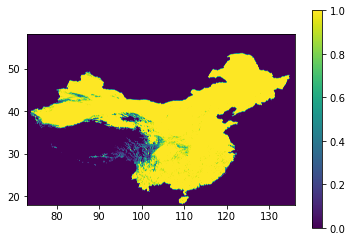

In [10]:
show(china.layers['slope'])

Some useful methods for the layers:

- `china.get_res()`: get resolution of each layer, in lat-lon coordinates
- `china.get_res(product = True)`: get grid cell size, in product of lat-lon coordinate differences
- `china.get_bounds()`: get bounds, in lat-lon coordinates

In [11]:
china.get_bounds()

{'slope': BoundingBox(left=72.99253346658085, bottom=17.994777314571174, right=136.0003674947241, top=58.23031889028454),
 'modis': BoundingBox(left=44.81844021698865, bottom=17.092253634655307, right=179.98824371508368, top=58.38850413860287)}

Note that the modis layer has a very different bounding box then the slope layer in lat-lon coordinate system. This is because the modis layer was converted to the lat-lon CRS from a different CRS when it was added to the object. The following section will explore the behind scene.

### 3.1 CRS conversion, trimming, cropping (if necessary)

Method `open_tif` can open a layer without adding it to the layer, this allows us to visualize it before-hand. It is a good practice to close the raster after openning it to avoid writing permission conflict issues.

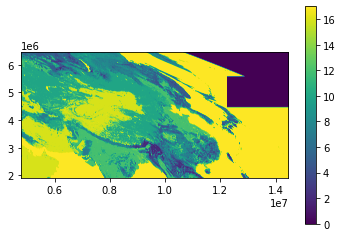

INFO:geodata.mask:Please remember to close the file with .close()


In [12]:
modis_openner = geodata.mask.open_tif(modis_path, show=True)
modis_openner.close()

We can use `remove_layer` method to remove a layer to mask `china`. This method will properly close the raster file.

In [13]:
china.remove_layer('modis')

The `add_layer` method incorporates CRS conversion. When the user pass in a path to a raster file, the program will automatically convert the CRS of the raster to the lat-lon CRS by default.

Note that this method will overwrite the layer by default, if it is in the object already, unless the user specifies `replace=True`. 

The method will automatically trim the all-zero columns/rows. By default, the paramater `trim` is set to `True`. If we do not set it to True, we might generate a converted raster with new CRS but many all-zero columns and rows.

INFO:geodata.mask:Raster MODIS_China.tif has been reprojected to EPSG:4326 CRS.
INFO:geodata.mask:Layer modis added to the mask China.


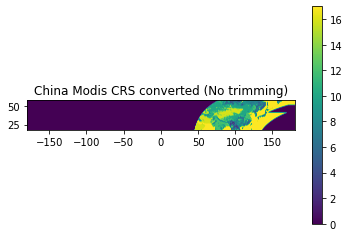

In [14]:
china.add_layer(modis_path, 'modis', trim = False)
show(china.layers['modis'], title = 'China Modis CRS converted (No trimming)')

We can also **arbitrary** crop a raster/layer: method `crop_layer` can take either starting indices of top/left, ending indices of right/bottom, or coordinates values in lat/long to trim the raster.

We also have a method `crop_raster` (`geodata.mask.crop_raster`) similarly to `crop_layer` but we can have any raster as input, which indicates that users do not need to add a raster as a layer to call that method. (Similar method: `trim_layer`/`trim_raster`, `binarize_layer`/`binarize_raster`)

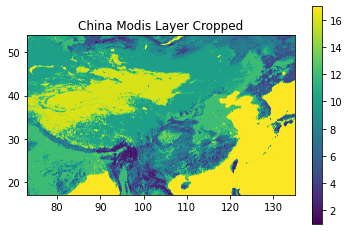

In [15]:
china.crop_layer('modis', bounds = (73, 17, 135, 54))
show(china.layers['modis'], title = 'China Modis Layer Cropped')

The line below performs the same function with the code block above in arbitrary cropping the modis layer.

In [16]:
china.layers['modis'] = geodata.mask.crop_raster(china.layers['modis'], (73, 17, 135, 54))

### 3.2 Categorical Value Extraction, if necessary

However, the modis layer have 17 distinct values, we may want to create a layer of binary values, indicating unavailable land as 0, and available land as 1.

Values 1, 2, 3, 4, 5 are 5 types of forest for the modis layer, let us use method `binarize_raster` to create a layer of `modis_forest` mask with 1 and 0. 1, 2, 3, 4, 5 will be unavailable land, therefore we need to take in the rest of the values to make them 1 (available).


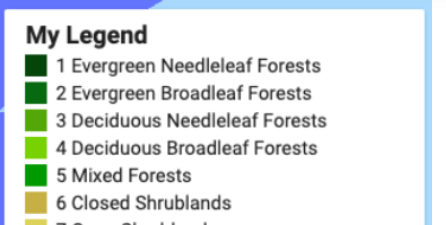

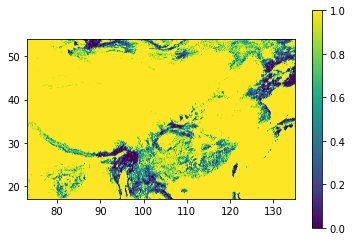

In [17]:
values = np.arange(6, 18)
china.layers['modis_forest'] = geodata.mask.binarize_raster(china.layers['modis'], values = values)
china.remove_layer('modis')
show(china.layers['modis_forest'])

## 4. Openning shapefile and adding shape features as a layer

Check attributes in the shapes contained in path `enep_shape_path`. The `shape_attribute` method checks the attribute of the features in the shapefile by showing the attribute-value pair of the first feature in the shapefile. 

In [18]:
geodata.mask.shape_attribute(enep_shape_path)

{'OBJECTID_1': 1,
 'FID_CHGIS_': 0,
 'OBJECTID': 1,
 'Shape_Leng': 403.364173808,
 'NAME_HZ': 'CN',
 'FID_WDPApo': 1094,
 'WDPAID': 555542691,
 'WDPA_PID': 0,
 'NAME': 'Hangzhou Xixi Wetlands',
 'ORIG_NAME': 'Hangzhou Xixi Wetlands',
 'COUNTRY': 'CHN',
 'SUB_LOC': 'CN-33',
 'DESIG': 'Ramsar Site, Wetland of International Importance',
 'DESIG_ENG': 'Ramsar Site, Wetland of International Importance',
 'DESIG_TYPE': 'International',
 'IUCN_CAT': 'Not Applicable',
 'INT_CRIT': 'Not Reported',
 'MARINE': '0',
 'REP_M_AREA': 0.0,
 'GIS_M_AREA': 0.0,
 'REP_AREA': 3.25,
 'GIS_AREA': 3.24987181454,
 'STATUS': 'Designated',
 'STATUS_YR': 2009,
 'GOV_TYPE': 'Not Reported',
 'MANG_AUTH': 'Not Reported',
 'MANG_PLAN': 'Not Reported',
 'NO_TAKE': 'Not Applicable',
 'NO_TK_AREA': 0.0,
 'METADATAID': 1712,
 'OBJECTID_2': 0,
 'SHAPE_Le_1': 0.0,
 'Shape_Le_2': 0.10055241716,
 'Shape_Area': 0.000303652040609}

Loading shapes with the `get_shape` method. It is more convenient to load the shapes into a python dictionary as a input for `add_shape_layer` method. If we do not specify `return_dict = True`, the result will be a geopandas dataframe. We will add the shapes to the china mask object.

There are more examples of the `get_shape` method later in this demo when we want to extract the chinese provinces from the mask.

In [19]:
protected_area_shapes = geodata.mask.get_shape(enep_shape_path, key = 'NAME', return_dict = True)
len(protected_area_shapes)

824

There are 824 shapes, but we want to add all the shapes to one new layer instead of 824 new layers. Therefore, in the `add_shape_layer` method, we will pecify `combine_name` so that the program will combine the features to one layer with the `combine_name` as its layer name.

We will also use `reference layer = 'slope'` so the new shape layer will have the same dimension with the `slope` layer. If the mask is empty and does not contain any layer, the user will have to specify the dimension as another parameter.

By default, this method will have paramater `invert` that defaults to `True`, and generate 1 for area covered by the shape, and 0 for the area outside of the shape. In this use case, however, we want 0 for area inside of the shape as they are the environmental protected area. We will specify `invert = False`.

INFO:geodata.mask:Layer protected added to the mask China.


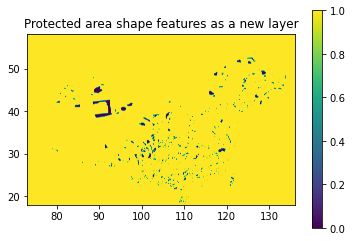

In [20]:
china.add_shape_layer(protected_area_shapes, 
                      reference_layer = 'slope', 
                      combine_name = 'protected',
                      invert = False)
show(china.layers['protected'], title = 'Protected area shape features as a new layer')

## 5. Merging and flattening layers

`merge_layer` method is important for merging all the layers, or the specified layers, into one single mask in object attribute called `merged_mask`.

It merges multiple layers together and flatten it using either **and** (default) or **sum** method, saving the result to `self.merged_mask` by default. Geospatial bounds and resolution of a new output file are in the units of the input file coordinate reference system, but by default, we will use the resolution of the layer with the best (finest) resolution for the output bounds/resolution, unless a reference layer is provided. In this case, the resolution of the merged_mask is the same with the `modis_forest` layer. 

In [21]:
china.get_res()

{'slope': (0.008983152841195215, 0.008983152841195215),
 'modis_forest': (0.006363926718366056, 0.006364039220827179),
 'protected': (0.008983152841195215, 0.008983152841195215)}

In [22]:
china.merge_layer(attribute_save = False, show = False).res

(0.008983152841195215, 0.008983152841195215)

### 4.1 binary AND method

By default, the `merge_layer` method will use a binary 'and' method: if any of the n grid cells of the n layers at the same location have 0, then the returned `self.merged_layer` will also have 0 at that location. In other words, if all the layers indicate that a land is not unavailable (!=0), the merged result will have value 1.

`merge_layer` may also take in an optional parameter `layers`, which is a list of layer names stored in the object. If users do not wish to create the final merged mask with all layers, they can specify which layers to use. If the user do not want to save the result of this method to the `merged_mask` attribute, the user can specify `attribute_save = False`. 

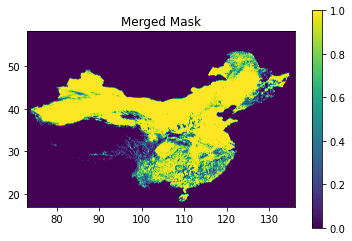

<open DatasetReader name='/vsimem/54d97050-425b-479a-bfaa-48a217f9b7cd/54d97050-425b-479a-bfaa-48a217f9b7cd.tif' mode='r'>

In [23]:
china.merge_layer(attribute_save = False, layers = ['slope', 'modis_forest'])

Try a different reference layer.

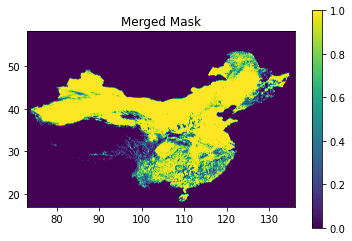

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


In [24]:
china.merge_layer(layers = ['slope', 'modis_forest'], reference_layer = 'slope')

Now the result of the `merged_mask` method is saved to `china.merged_mask`, and the resolution of the `merged_mask` is the same with the `slope` reference layer. 

In [25]:
china.merged_mask.res

(0.008983152841195215, 0.008983152841195215)

### 4.2 sum method

The sum method will add up the values from all the layers. We can also customize the weights. The behind scene of this method is that it multiplys each layers with the corresponding weight, and add the in-memory temporary layers together.

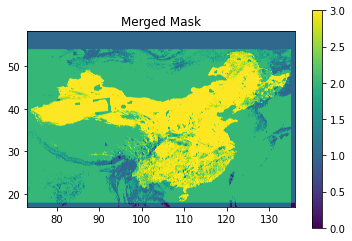

INFO:geodata.mask:Overwriting current merged_mask.
INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


In [26]:
china.merge_layer(method = 'sum')

In [27]:
china

Mask China: 
3 layers: ['slope', 'modis_forest', 'protected'].
Merged_mask merged/flattened. 
No shape has been extracted. 
Mask has not been saved/updated. 

This distribution is completely arbitrary for the purpose of demonstration of the module:
- slope: 25%, modis_forest: 30%, protected 45%

The weights do not need to have a total of 1.

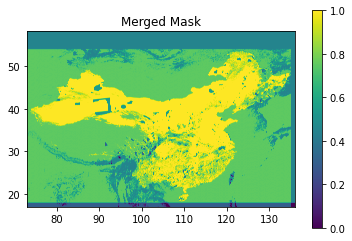

INFO:geodata.mask:Overwriting current merged_mask.
INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


In [28]:
china.merge_layer(method = 'sum', weights = {
    'slope': 0.25,
    'modis_forest': 0.3,
    'protected': 0.45
})

We can also trim the border of the merged mask since not 4 layers have the same boundary, and the border values are not useful. We can set the parameter `trim = True`.

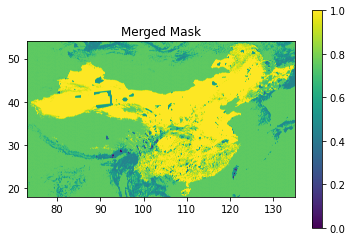

INFO:geodata.mask:Overwriting current merged_mask.
INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


In [29]:
china.merge_layer(method = 'sum', weights = {'slope': 0.25, 'modis_forest': 0.3, 'protected': 0.45},
                 trim = True)

## 5.0 Extracting shapes from mask

Let us get province shapes from `cartopy` and save the path as `prov_path`. This can also be the path to user-supplied shape files.

In [30]:
prov_path = shpreader.natural_earth(resolution='10m', category='cultural', name = 'admin_1_states_provinces')
prov_path

'C:\\Users\\fengj\\.local\\share\\cartopy\\shapefiles\\natural_earth\\cultural\\ne_10m_admin_1_states_provinces.shp'

Check attributes in the shapes contained in path `prov_path`.

In [31]:
geodata.mask.shape_attribute(prov_path)

{'featurecla': 'Admin-1 scale rank',
 'scalerank': 3,
 'adm1_code': 'ARG-1309',
 'diss_me': 1309,
 'iso_3166_2': 'AR-E',
 'wikipedia': None,
 'iso_a2': 'AR',
 'adm0_sr': 1,
 'name': 'Entre RÃ\xados',
 'name_alt': 'Entre-Rios',
 'name_local': None,
 'type': 'Provincia',
 'type_en': 'Province',
 'code_local': None,
 'code_hasc': 'AR.ER',
 'note': None,
 'hasc_maybe': None,
 'region': None,
 'region_cod': None,
 'provnum_ne': 10,
 'gadm_level': 1,
 'check_me': 20,
 'datarank': 3,
 'abbrev': None,
 'postal': 'ER',
 'area_sqkm': 0,
 'sameascity': -99,
 'labelrank': 3,
 'name_len': 10,
 'mapcolor9': 3,
 'mapcolor13': 13,
 'fips': 'AR08',
 'fips_alt': None,
 'woe_id': 2344682,
 'woe_label': 'Entre Rios, AR, Argentina',
 'woe_name': 'Entre RÃ\xados',
 'latitude': -32.0275,
 'longitude': -59.2824,
 'sov_a3': 'ARG',
 'adm0_a3': 'ARG',
 'adm0_label': 2,
 'admin': 'Argentina',
 'geonunit': 'Argentina',
 'gu_a3': 'ARG',
 'gn_id': 3434137,
 'gn_name': 'Provincia de Entre Rios',
 'gns_id': -988655,
 

For the `get_shape` method, while the targets list the exact names/value of key_name attributes of the shapes, users may also ignore it and use condition_key and condition_value to find the desired shapes. For example, the call below will find all the shapes of provinces that belongs to China:
`mask.get_shape(path_to_province_shapes, key = 'name', condition_key = 'admin', condition_value = 'China')`

In [32]:
china_all_shapes = geodata.mask.get_shape(prov_path, key = 'name_en',
condition_key = 'admin', condition_value = 'China')
china_all_shapes

,name_en,shapes
0,Xinjiang,"POLYGON ((77.88313195800004 35.43106842000005,..."
1,Tibet,"POLYGON ((78.91769413200012 33.38625783300004,..."
2,Inner Mongolia,"POLYGON ((115.9145056560001 47.68391225200013,..."
3,Gansu,"POLYGON ((96.36633990096561 42.72292261928345,..."
4,Yunnan,"POLYGON ((101.8679211830001 22.37884185800006,..."
5,Heilongjiang,"POLYGON ((123.2773120530001 53.56944447900007,..."
6,Jilin,"POLYGON ((131.2528484626863 43.46916859125747,..."
7,Liaoning,(POLYGON ((125.7040896919857 40.85919462483207...
8,Guangxi Zhuang Autonomous Region,(POLYGON ((105.6649503990001 23.04337493900003...
9,Guangdong,"(POLYGON ((114.183035116 22.55619537400004, 11..."


We can also ignore condition, just take three provinces of China by naming them out:

In [33]:
china_shapes = geodata.mask.get_shape(prov_path, key = 'name_en',
                         targets = ['Jiangsu', 'Zhejiang', 'Shanghai'],
                         return_dict = True)
china_shapes

{'Zhejiang': <shapely.geometry.multipolygon.MultiPolygon at 0x265002646d0>,
 'Shanghai': <shapely.geometry.multipolygon.MultiPolygon at 0x26500264fd0>,
 'Jiangsu': <shapely.geometry.multipolygon.MultiPolygon at 0x26500264eb0>}

Extract the shapes from the merged_mask.

In [34]:
china.extract_shapes(china_shapes)

INFO:geodata.mask:Extracted shape Zhejiang added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Shanghai added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Jiangsu added to attribute 'shape_mask'.


In [35]:
china

Mask China: 
3 layers: ['slope', 'modis_forest', 'protected'].
Merged_mask merged/flattened. 
3 shape_mask: ['Zhejiang', 'Shanghai', 'Jiangsu']. 
Mask has not been saved/updated. 

## 6. Saving and Loading masks

In [36]:
china.save_mask()

INFO:geodata.mask:Mask China successfully saved at D:/Users/davison_lab_data/masks


Note that since "Mask has been saved", we can now load the layers or shapes with xarray.

INFO:geodata.mask:Please close the shape_mask xarray(s) for further changes of the mask object.


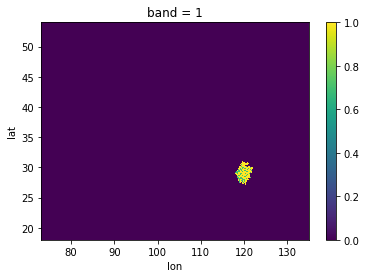

In [37]:
shape_xr_lst = china.load_shape_xr()
shape_xr_lst['Zhejiang'].plot()

Optional: closing all the files when saving the mask. This can avoid possible write permission error.

In [38]:
china.save_mask(close_files = True)

INFO:geodata.mask:Mask China successfully saved at D:/Users/davison_lab_data/masks


Loading a previously saved mask

In [39]:
china_2 = geodata.mask.load_mask("china")

INFO:geodata.mask:Layer ['modis_forest', 'protected', 'slope'] loaded to the mask china.
INFO:geodata.mask:Merged_mask loaded to the mask china.
INFO:geodata.mask:Shape mask ['Jiangsu', 'Shanghai', 'Zhejiang'] loaded to the mask china.


In [40]:
china_2

Mask china: 
3 layers: ['modis_forest', 'protected', 'slope'].
Merged_mask merged/flattened. 
3 shape_mask: ['Jiangsu', 'Shanghai', 'Zhejiang']. 
Mask has been saved. 